<a href="https://colab.research.google.com/github/Deviloxide/Codeday-Project/blob/sentiment-notebook/Vaccine_Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

Added GPU to speed up the training process


In [1]:
!nvidia-smi

Thu Jul 28 05:14:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

All the required libraries and dependiencies can be installed using:

In [2]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.1 MB/s 
     |████████████████████████████████| 596 kB 52.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.9 MB/s 
     |████████████████████████████████| 101 kB 11.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Imported all the neccessary modules and set the formating of the graphs

Also checks to make sure that the device is using GPU if it is available 

Two key modules used in this project is the TextBlob library and the transformers library.

The TextBlob library is used in the intial anaylsis of the sentiment of the the tweets

Then the transformers library from huggingface is used to access the BERT model used to train a model to analyze the sentiments of any new tweets

In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import re
from textblob import TextBlob

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data 

The dataset used is located in a csv file. Here we are formating all the column names so that data visualization can be done more easily in the future, and checking the fist few values to make sure everything looks good.

In [4]:
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv("covid_vaccine_tweets.csv",encoding=DATASET_ENCODING)
df.head() 

,Unnamed: 0,ids,name,location,user_desc,user_created,follow,friends,likes,verified,date,text,hashtag,source,retweets,favourites,is_retweeted
0,14,1337809196453081088,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 17:19:02,For all the women and healthcare providers who...,['PfizerBioNTech'],Twitter for iPhone,48,82,False
1,20,1337776763384958976,Alex Vie,"Los Angeles, CA",Marine vet. Yogi. Krav Maga. Runner. Climber. ...,2010-01-24 04:43:57,125,442,5401,False,2020-12-12 15:10:09,The trump administration failed to deliver on ...,"['COVIDIOTS', 'coronavirus', 'CovidVaccine']",Twitter for iPhone,0,0,False
2,30,1337761915087560707,Ã°ÂÂ¦ÂDr. Kraken-Elect Lipstick Ã°ÂÂÂ,Not Today,Married. National news investigative/independe...,2011-06-01 17:10:58,5166,5228,19389,False,2020-12-12 14:11:09,Ã°ÂÂÂ #Vaccine #TrumpVaccine #AstraZeneca #...,"['Vaccine', 'TrumpVaccine', 'AstraZeneca', 'Pf...",Twitter for iPhone,0,0,False
3,44,1337728701820268544,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,Trump announces #vaccine rollout 'in less than...,['vaccine'],Twitter Web App,0,2,False
4,49,1339891037712637952,Euranet Plus,The European Union,The leading radio network for EU news,2013-03-29 13:30:06,6006,3551,3954,False,2020-12-18 11:11:32,As @EMA_News gets set to approve #PfizerBioNTe...,"['PfizerBioNTech', 'vaccine', 'EU']",Twitter Web App,2,0,False


The intial dataset is a collection of over 800,000 COVID-19 vaccine tweets. This is a small sample of that and currently holds 60 thousand tweets, and after removing any null values the size reduces down to around 31 thousand.

In [5]:
df.shape

(61616, 17)

In [6]:
df = df.dropna() #Removes null values

In [7]:
df.shape

(31447, 17)

The tweets are cleaned up to remove any @ symbols, hyper links,punctuation and retweets, so that the sentiment analysis can be more accurate.


In [8]:
from string import punctuation
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #Removes @mentions
    text = re.sub(r'#','', text) #Removing the '#' symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+','', text) #Remove the hyper link
    text = "".join([ch for ch in text if ch not in punctuation])
    return text

#Cleaning text
df['text'] = df['text'].apply(cleanTxt)

#Show the cleaned text
df.head(10)

,Unnamed: 0,ids,name,location,user_desc,user_created,follow,friends,likes,verified,date,text,hashtag,source,retweets,favourites,is_retweeted
1,20,1337776763384958976,Alex Vie,"Los Angeles, CA",Marine vet. Yogi. Krav Maga. Runner. Climber. ...,2010-01-24 04:43:57,125,442,5401,False,2020-12-12 15:10:09,The trump administration failed to deliver on ...,"['COVIDIOTS', 'coronavirus', 'CovidVaccine']",Twitter for iPhone,0,0,False
2,30,1337761915087560707,Ã°ÂÂ¦ÂDr. Kraken-Elect Lipstick Ã°ÂÂÂ,Not Today,Married. National news investigative/independe...,2011-06-01 17:10:58,5166,5228,19389,False,2020-12-12 14:11:09,Ã°ÂÂÂ Vaccine TrumpVaccine AstraZeneca Pfiz...,"['Vaccine', 'TrumpVaccine', 'AstraZeneca', 'Pf...",Twitter for iPhone,0,0,False
3,44,1337728701820268544,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,Trump announces vaccine rollout in less than 2...,['vaccine'],Twitter Web App,0,2,False
4,49,1339891037712637952,Euranet Plus,The European Union,The leading radio network for EU news,2013-03-29 13:30:06,6006,3551,3954,False,2020-12-18 11:11:32,As News gets set to approve PfizerBioNTech vac...,"['PfizerBioNTech', 'vaccine', 'EU']",Twitter Web App,2,0,False
6,52,1338631874814619653,Dr. Taha Khan,India | USA,MD/MPH Ã¢ÂÂ¢ PGY1 Peds/Child Neurology @theBC...,2013-12-30 08:51:23,855,3046,8236,False,2020-12-14 23:48:04,IÃ¢ÂÂve never been so excited to get a vacci...,"['CovidVaccine', 'PfizerBioNTech', 'VaccinesSa...",Twitter for iPhone,1,10,False
7,54,1338623197390852100,theDove,"Medford, OR",theDove | Radio | TV | Online | Mobile Providi...,2009-11-24 18:02:18,649,439,342,False,2020-12-14 23:13:35,The first COVID19 vaccine doses have arrived i...,['MorningsontheDove'],TweetDeck,1,0,False
9,68,1338590172523470848,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 21:02:21,Screenshot 2 of that QP exchange \n\nUnfor...,['QP'],Twitter Web App,1,5,False
15,85,1338565957866778624,Genevieve Reaume,"Oregon, USA",Emmy-award winning @KATUnews reporter Ã¢ÂÂ¢ s...,2015-06-22 18:41:01,4276,1704,5877,True,2020-12-14 19:26:08,The state is supposed to get 35100 doses total...,['PfizerBioNTech'],Twitter Web App,0,0,False
16,87,1338565238082265089,Genevieve Reaume,"Oregon, USA",Emmy-award winning @KATUnews reporter Ã¢ÂÂ¢ s...,2015-06-22 18:41:01,4276,1704,5877,True,2020-12-14 19:23:16,BREAKING just in from on COVID19 vaccine\nLe...,"['BREAKING', 'COVID19', 'vaccine']",Twitter Web App,1,6,False
17,88,1338564311518769152,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 19:19:35,Ã°ÂÂÂÃ°ÂÂÂ¼Ã¢ÂÂÃ¢ÂÂÃ¯Â¸Â Ruhroh An...,['QP'],Twitter Web App,3,16,False


Using the TextBlob library, the subjectivity and polarity of the text can be analyzed.

In [9]:
# Create a function to get the subjectivity 
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns
df['Subjectivity'] = df['text'].apply(getSubjectivity)
df['Polarity'] = df['text'].apply(getPolarity)

#Show the new dataframe with the new columns
df.head(10)

,Unnamed: 0,ids,name,location,user_desc,user_created,follow,friends,likes,verified,date,text,hashtag,source,retweets,favourites,is_retweeted,Subjectivity,Polarity
1,20,1337776763384958976,Alex Vie,"Los Angeles, CA",Marine vet. Yogi. Krav Maga. Runner. Climber. ...,2010-01-24 04:43:57,125,442,5401,False,2020-12-12 15:10:09,The trump administration failed to deliver on ...,"['COVIDIOTS', 'coronavirus', 'CovidVaccine']",Twitter for iPhone,0,0,False,0.300000,-0.500000
2,30,1337761915087560707,Ã°ÂÂ¦ÂDr. Kraken-Elect Lipstick Ã°ÂÂÂ,Not Today,Married. National news investigative/independe...,2011-06-01 17:10:58,5166,5228,19389,False,2020-12-12 14:11:09,Ã°ÂÂÂ Vaccine TrumpVaccine AstraZeneca Pfiz...,"['Vaccine', 'TrumpVaccine', 'AstraZeneca', 'Pf...",Twitter for iPhone,0,0,False,0.000000,0.000000
3,44,1337728701820268544,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,Trump announces vaccine rollout in less than 2...,['vaccine'],Twitter Web App,0,2,False,0.200000,0.041667
4,49,1339891037712637952,Euranet Plus,The European Union,The leading radio network for EU news,2013-03-29 13:30:06,6006,3551,3954,False,2020-12-18 11:11:32,As News gets set to approve PfizerBioNTech vac...,"['PfizerBioNTech', 'vaccine', 'EU']",Twitter Web App,2,0,False,0.000000,0.000000
6,52,1338631874814619653,Dr. Taha Khan,India | USA,MD/MPH Ã¢ÂÂ¢ PGY1 Peds/Child Neurology @theBC...,2013-12-30 08:51:23,855,3046,8236,False,2020-12-14 23:48:04,IÃ¢ÂÂve never been so excited to get a vacci...,"['CovidVaccine', 'PfizerBioNTech', 'VaccinesSa...",Twitter for iPhone,1,10,False,0.750000,0.375000
7,54,1338623197390852100,theDove,"Medford, OR",theDove | Radio | TV | Online | Mobile Providi...,2009-11-24 18:02:18,649,439,342,False,2020-12-14 23:13:35,The first COVID19 vaccine doses have arrived i...,['MorningsontheDove'],TweetDeck,1,0,False,0.333333,0.250000
9,68,1338590172523470848,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 21:02:21,Screenshot 2 of that QP exchange \n\nUnfor...,['QP'],Twitter Web App,1,5,False,1.000000,-0.500000
15,85,1338565957866778624,Genevieve Reaume,"Oregon, USA",Emmy-award winning @KATUnews reporter Ã¢ÂÂ¢ s...,2015-06-22 18:41:01,4276,1704,5877,True,2020-12-14 19:26:08,The state is supposed to get 35100 doses total...,['PfizerBioNTech'],Twitter Web App,0,0,False,0.750000,0.000000
16,87,1338565238082265089,Genevieve Reaume,"Oregon, USA",Emmy-award winning @KATUnews reporter Ã¢ÂÂ¢ s...,2015-06-22 18:41:01,4276,1704,5877,True,2020-12-14 19:23:16,BREAKING just in from on COVID19 vaccine\nLe...,"['BREAKING', 'COVID19', 'vaccine']",Twitter Web App,1,6,False,0.333333,0.250000
17,88,1338564311518769152,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 19:19:35,Ã°ÂÂÂÃ°ÂÂÂ¼Ã¢ÂÂÃ¢ÂÂÃ¯Â¸Â Ruhroh An...,['QP'],Twitter Web App,3,16,False,0.000000,0.000000


The TextBlob polarity scales ranges from -1 to 1. If the score is less than 0, it's an negative sentiment, if it's zero it's a neutral sentiment, and if it's more than 0, it's a positve sentiment

In [10]:
def getAnalysis(score):
    if score < 0:
        return 0
    elif score == 0:
        return 1
    else:
        return 2

df['sentiment'] = df['Polarity'].apply(getAnalysis)

df.head(20)

,Unnamed: 0,ids,name,location,user_desc,user_created,follow,friends,likes,verified,date,text,hashtag,source,retweets,favourites,is_retweeted,Subjectivity,Polarity,sentiment
1,20,1337776763384958976,Alex Vie,"Los Angeles, CA",Marine vet. Yogi. Krav Maga. Runner. Climber. ...,2010-01-24 04:43:57,125,442,5401,False,2020-12-12 15:10:09,The trump administration failed to deliver on ...,"['COVIDIOTS', 'coronavirus', 'CovidVaccine']",Twitter for iPhone,0,0,False,0.300000,-0.500000,0
2,30,1337761915087560707,Ã°ÂÂ¦ÂDr. Kraken-Elect Lipstick Ã°ÂÂÂ,Not Today,Married. National news investigative/independe...,2011-06-01 17:10:58,5166,5228,19389,False,2020-12-12 14:11:09,Ã°ÂÂÂ Vaccine TrumpVaccine AstraZeneca Pfiz...,"['Vaccine', 'TrumpVaccine', 'AstraZeneca', 'Pf...",Twitter for iPhone,0,0,False,0.000000,0.000000,1
3,44,1337728701820268544,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,Trump announces vaccine rollout in less than 2...,['vaccine'],Twitter Web App,0,2,False,0.200000,0.041667,2
4,49,1339891037712637952,Euranet Plus,The European Union,The leading radio network for EU news,2013-03-29 13:30:06,6006,3551,3954,False,2020-12-18 11:11:32,As News gets set to approve PfizerBioNTech vac...,"['PfizerBioNTech', 'vaccine', 'EU']",Twitter Web App,2,0,False,0.000000,0.000000,1
6,52,1338631874814619653,Dr. Taha Khan,India | USA,MD/MPH Ã¢ÂÂ¢ PGY1 Peds/Child Neurology @theBC...,2013-12-30 08:51:23,855,3046,8236,False,2020-12-14 23:48:04,IÃ¢ÂÂve never been so excited to get a vacci...,"['CovidVaccine', 'PfizerBioNTech', 'VaccinesSa...",Twitter for iPhone,1,10,False,0.750000,0.375000,2
7,54,1338623197390852100,theDove,"Medford, OR",theDove | Radio | TV | Online | Mobile Providi...,2009-11-24 18:02:18,649,439,342,False,2020-12-14 23:13:35,The first COVID19 vaccine doses have arrived i...,['MorningsontheDove'],TweetDeck,1,0,False,0.333333,0.250000,2
9,68,1338590172523470848,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 21:02:21,Screenshot 2 of that QP exchange \n\nUnfor...,['QP'],Twitter Web App,1,5,False,1.000000,-0.500000,0
15,85,1338565957866778624,Genevieve Reaume,"Oregon, USA",Emmy-award winning @KATUnews reporter Ã¢ÂÂ¢ s...,2015-06-22 18:41:01,4276,1704,5877,True,2020-12-14 19:26:08,The state is supposed to get 35100 doses total...,['PfizerBioNTech'],Twitter Web App,0,0,False,0.750000,0.000000,1
16,87,1338565238082265089,Genevieve Reaume,"Oregon, USA",Emmy-award winning @KATUnews reporter Ã¢ÂÂ¢ s...,2015-06-22 18:41:01,4276,1704,5877,True,2020-12-14 19:23:16,BREAKING just in from on COVID19 vaccine\nLe...,"['BREAKING', 'COVID19', 'vaccine']",Twitter Web App,1,6,False,0.333333,0.250000,2
17,88,1338564311518769152,Joanbeam3000,La Belle Province,"Be yourself, everyone else is already taken. ~...",2014-10-06 04:28:08,2597,4988,338282,False,2020-12-14 19:19:35,Ã°ÂÂÂÃ°ÂÂÂ¼Ã¢ÂÂÃ¢ÂÂÃ¯Â¸Â Ruhroh An...,['QP'],Twitter Web App,3,16,False,0.000000,0.000000,1


In [11]:
df.shape

(31447, 20)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31447 entries, 1 to 61614
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    31447 non-null  int64  
 1   ids           31447 non-null  int64  
 2   name          31447 non-null  object 
 3   location      31447 non-null  object 
 4   user_desc     31447 non-null  object 
 5   user_created  31447 non-null  object 
 6   follow        31447 non-null  int64  
 7   friends       31447 non-null  int64  
 8   likes         31447 non-null  int64  
 9   verified      31447 non-null  bool   
 10  date          31447 non-null  object 
 11  text          31447 non-null  object 
 12  hashtag       31447 non-null  object 
 13  source        31447 non-null  object 
 14  retweets      31447 non-null  int64  
 15  favourites    31447 non-null  int64  
 16  is_retweeted  31447 non-null  bool   
 17  Subjectivity  31447 non-null  float64
 18  Polarity      31447 non-nu

Next important thing to check if there is a imbalance between the different classes. As seen there seems to be significantly more neutral and positive values for our dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


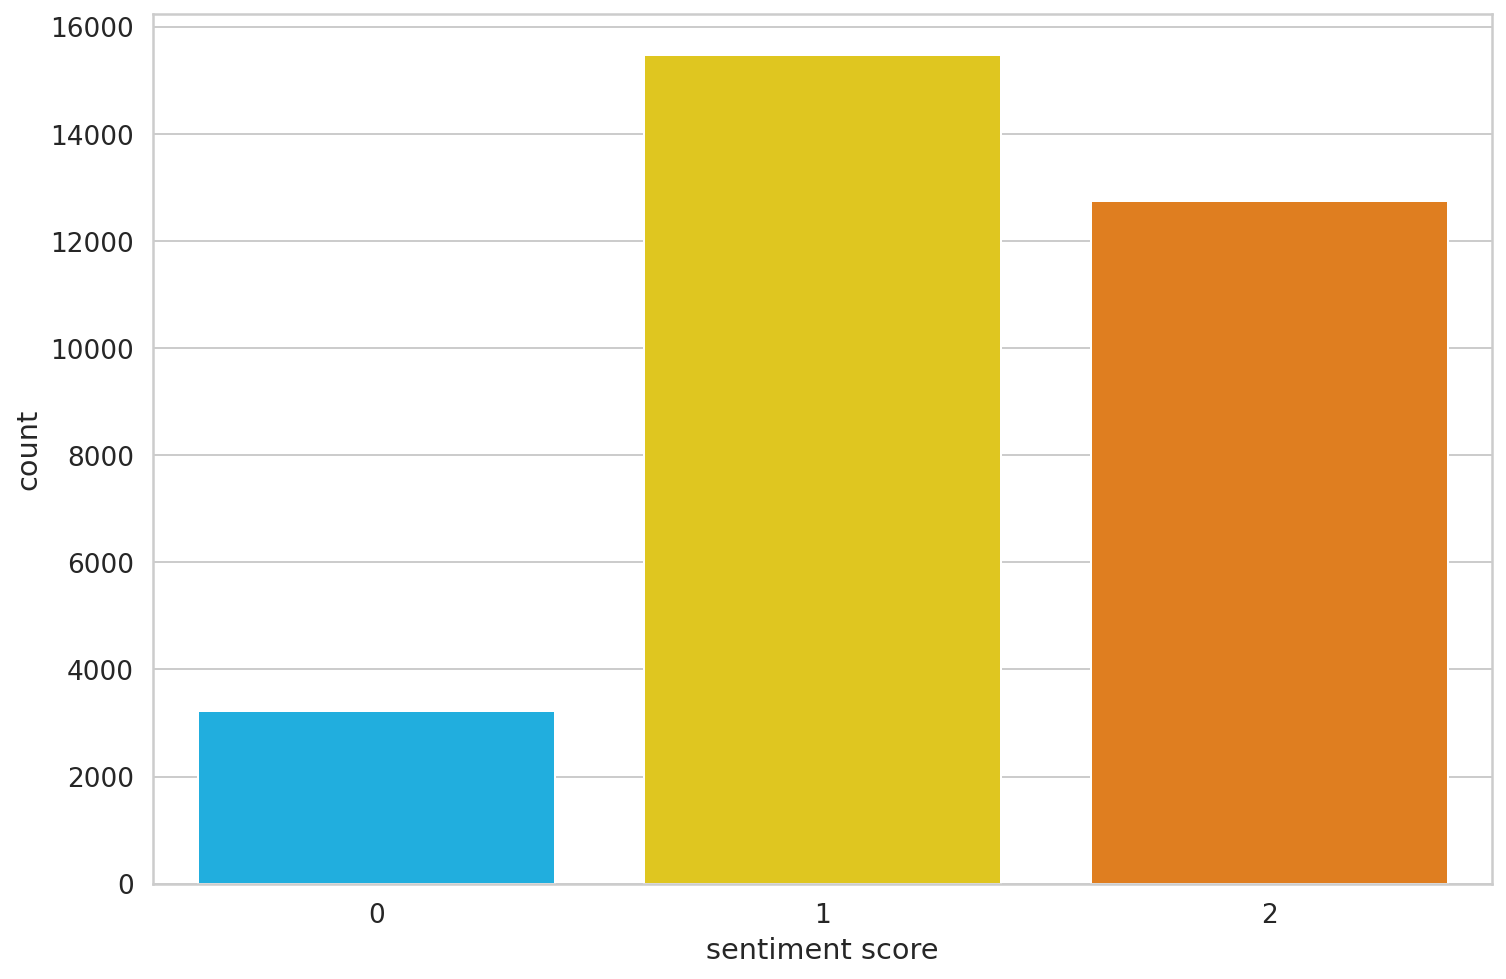

In [13]:
sns.countplot(df.sentiment)
plt.xlabel('sentiment score');

To balance the classes I will be undersampling the data, and reduce the neutral and postive so they have the same amount as the negative tweets.

In [14]:
#Number of negative tweets
ntweets = df[df.sentiment == 0]
print(ntweets.shape[0]) #we will make it so we undersample

3232


In [15]:
#Number of neutral tweets
netweet = df[df.sentiment == 1]
print(netweet.shape[0])

15470


In [16]:
#Number of positive tweets
ptweet = df[df.sentiment == 2]
print(ptweet.shape[0]) 

12745


In [17]:
#Randomly remove tweets from the other classes so they have the same number of tweets as the negative one
remove_pos = ptweet.shape[0] - ntweets.shape[0]
remove_neut = netweet.shape[0] - ntweets.shape[0]

neg_df = df[df["sentiment"] == 0] 

pos_df = df[df["sentiment"] == 2]
neut_df = df[df["sentiment"] == 1]

pos_drop_indices = np.random.choice(pos_df.index, remove_pos, replace=False)
neut_drop_indices = np.random.choice(neut_df.index, remove_neut, replace=False)

pos_undersampled = pos_df.drop(pos_drop_indices)
neut_undersampled = neut_df.drop(neut_drop_indices)

In [18]:
df= pd.concat([neg_df, pos_undersampled, neut_undersampled])

In [19]:
class_names = ['negative', 'neutral', 'positive']

Now all of the sets are the same size, and the final size of our set is around a thousand.

9696


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


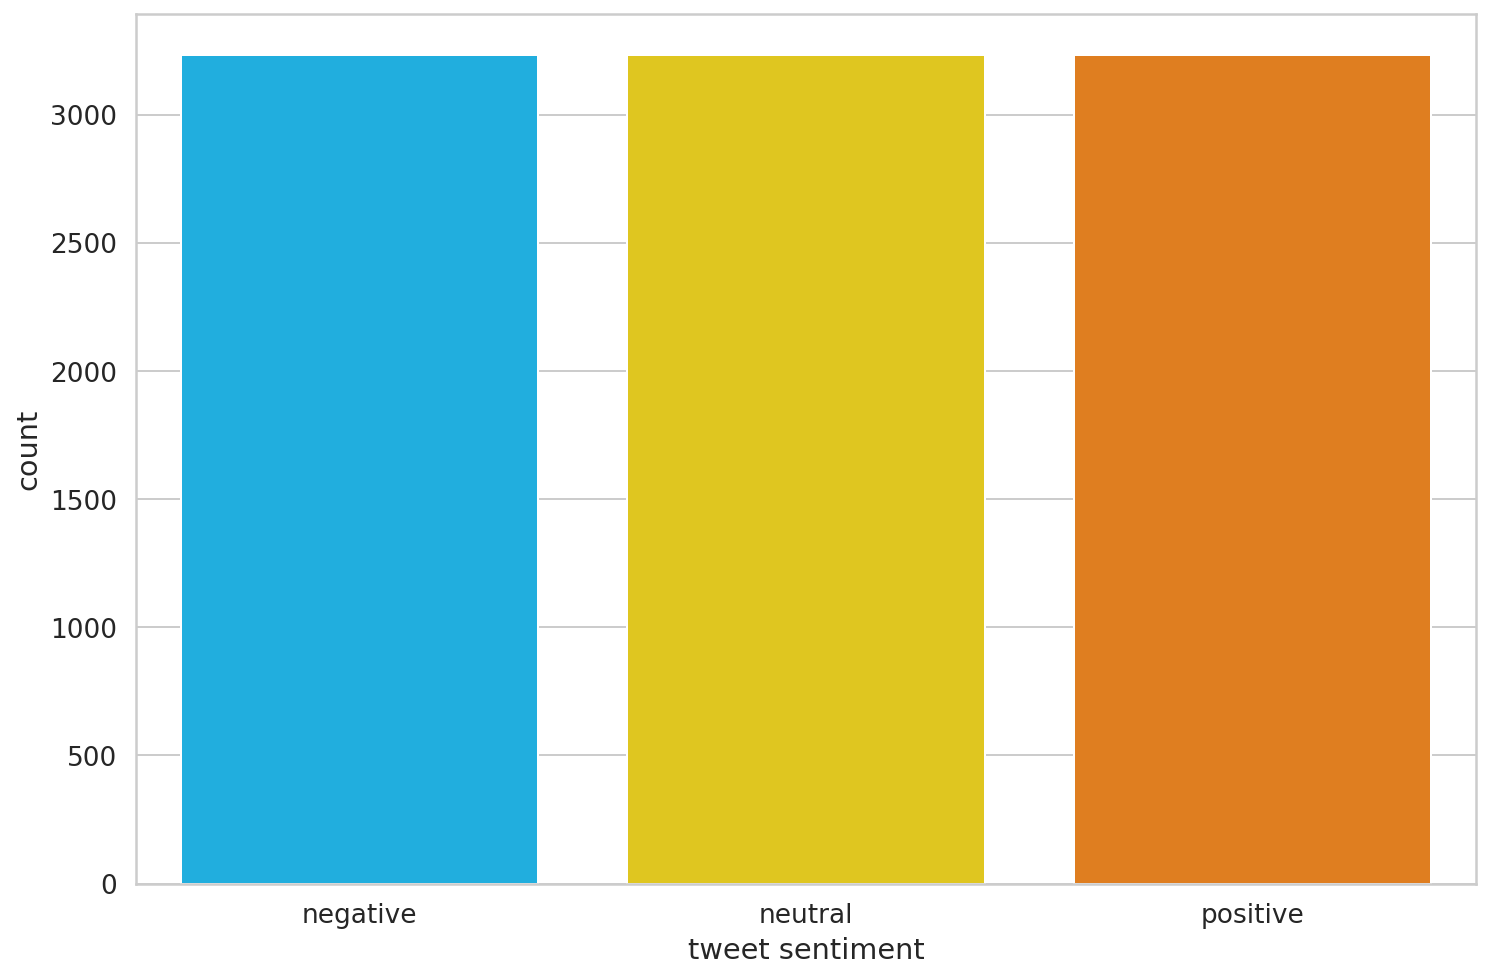

In [20]:
ax = sns.countplot(df.sentiment)
plt.xlabel('tweet sentiment')
ax.set_xticklabels(class_names);
df.head(10)
print(df.shape[0])

#Data Preprocessing

The tokenizer used is from the transformers library that is the pre-trained model from huggingface.

In [21]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [22]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


The BERT model requires special tokens to work on texts. Some of these prebuilt bodels include:

`[CLS]` - required at the start of each text to know that the text needs to be classified

`[SEP]` - marker for ending of a sentence

`[PAD]` - token is used to pad the texts up to a given length

Attention mask, a binary tensor, is also used so that the model knows to pay attention to the tokens that include text or markers, but not to pay attention to the padding

###Sample:
This is all the preprocessing steps shown on an example text

In [23]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [24]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [25]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [27]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

# Actual process

In [29]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


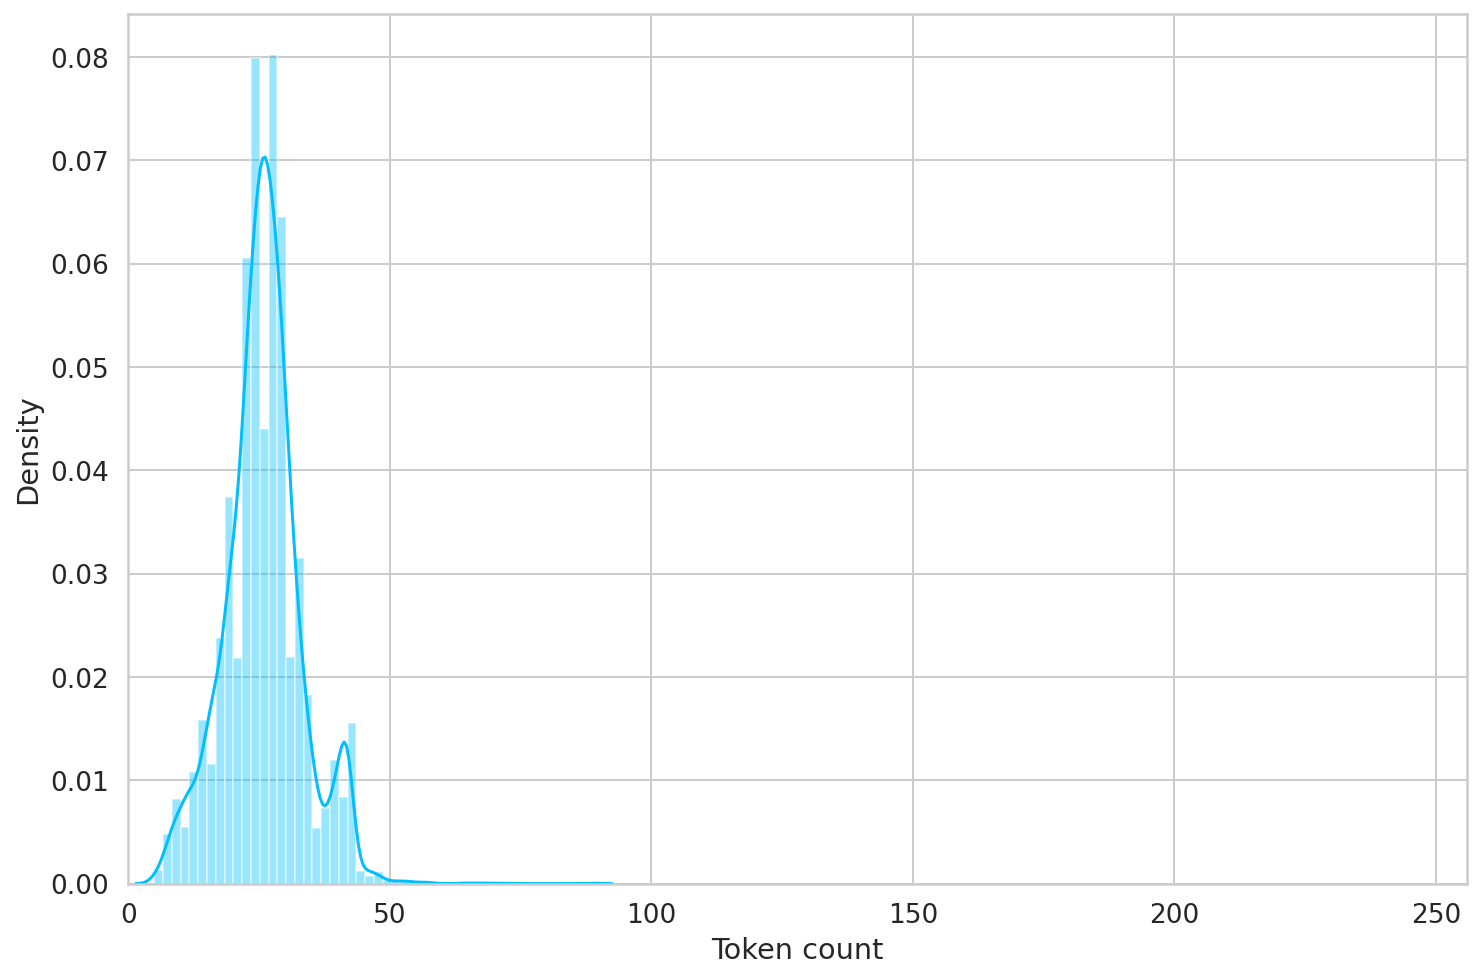

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

As most of the text are around 100 tokens long, the maximum length we chose was a little bit bigger at 150

In [31]:
MAX_LEN = 150

Here we created the Pytorch dataset. In the encoding section, it encodes each indivdual tweet, adds the special tokens and pads it to the maximum length. It also uses attention mask to emphasive the text portion of the tweets, as mentioned before

In [32]:
class GPTweetDataset(Dataset):

  def __init__(self, tweet, targets, tokenizer, max_len):
    self.tweet = tweet
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweet)
  
  def __getitem__(self, item):
    tweet = str(self.tweet[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Here we are splitting the train, test and validation sets, so that the training set makes up the majority of the data, with validation and testing being a small section of the rest

In [33]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [34]:
df_train.shape, df_val.shape, df_test.shape

((8726, 20), (485, 20), (485, 20))

This function is used to create some data loaders using the GPTweet class defined above, using Pytorch's built in primitives

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPTweetDataset(
    tweet=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

We used 16 mini-batches for the dataloader

In [36]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

The data iterates over the data_loader and is comprised of the batch size and the sequence length 

In [37]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


# Sentiment Classification using the BERT model

For the sentiment classification, we used the base version of the pretrained BERT model with 12 encoders, and it is also set to 'cased' to be case-sensitive, as capitalization can provide more emphasive, and can show more sentiment

In [39]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict = False   # this is needed to get a tensor as result
)

The last hidden state is a sequence of hidden states from the last layer of the model:

In [41]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [42]:
pooled_output.shape

torch.Size([1, 768])

In [43]:
bert_model.config.hidden_size

768

This class is the Sentiment Classifer that uses the pretrained model for the classification, and the dropout layer for regulization. All of this is then put into the model, which is moved into the GPU

In [44]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask,return_dict ):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [45]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The input ids and the attention mask is also moved into the GPU for the softmax model that is applied later

In [46]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size, seq length
print(attention_mask.shape) # batch size, seq length

torch.Size([16, 150])
torch.Size([16, 150])


This shows the untrained version of the model and the probabilites of each of the three sentiments

In [47]:
return_dict = False
F.softmax(model(input_ids, attention_mask=attention_mask, return_dict=return_dict) , dim=1)

tensor([[0.2041, 0.4713, 0.3246],
        [0.2266, 0.3523, 0.4211],
        [0.3475, 0.2630, 0.3895],
        [0.2090, 0.3505, 0.4405],
        [0.5495, 0.2154, 0.2351],
        [0.2493, 0.3771, 0.3736],
        [0.2413, 0.3570, 0.4017],
        [0.3785, 0.2170, 0.4044],
        [0.4017, 0.2073, 0.3910],
        [0.3364, 0.1839, 0.4797],
        [0.3113, 0.1924, 0.4963],
        [0.3354, 0.2015, 0.4630],
        [0.2258, 0.3885, 0.3856],
        [0.3024, 0.2685, 0.4291],
        [0.3251, 0.2538, 0.4211],
        [0.1409, 0.3601, 0.4990]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training
The optimizer used is the AdamW algorithm, which is based on the one used in the original BERT paper
The number of epochs are set to 10 and is used to calculate the total number of steps. 
The loss function is also defined and the built in CrossEntropyLoss is used


In [48]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


This is the training function, that takes in all the neccessary values. It iterates over the dataloader and takes the outputs of the model, to make a prediction on the most likely sentiment and the loss. The correct predictions are incremented, and the loss is backproporated and gradient clipping is applied to the model.

The entire function returns the number of correct predictions and the mean loss 

In [49]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return float(correct_predictions) / n_examples , np.mean(losses)

This function evaluates the model, by disabiling the gradient function and dropout, and doing the same steps as in the train function by iterating over the dataloader, collectiong the loss and correct predictions

In [50]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
      losses.append(loss.item())

  return float(correct_predictions) / n_examples, np.mean(losses)

This section creates the training group and shows the training loss and accuracy and the validation losss and accuracy. It runs through all the epochs, and the training data goes into the train function, and the validation data goes into the evaluation function. It also saves the model with the best accuracy and improves future accuracy using that.

In [51]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5831143081413357 accuracy 0.7591107036442815
Val   loss 0.3607363628764306 accuracy 0.8969072164948454

Epoch 2/10
----------
Train loss 0.2133245311362751 accuracy 0.9381159752463901
Val   loss 0.3748740117035566 accuracy 0.9175257731958762

Epoch 3/10
----------
Train loss 0.10615911807183896 accuracy 0.9730689892275957
Val   loss 0.4045107796405172 accuracy 0.9175257731958762

Epoch 4/10
----------
Train loss 0.060760382076959045 accuracy 0.9853311941324776
Val   loss 0.4684597644569998 accuracy 0.931958762886598

Epoch 5/10
----------
Train loss 0.03320115522037268 accuracy 0.9924363969745588
Val   loss 0.5203199676358171 accuracy 0.9257731958762887

Epoch 6/10
----------
Train loss 0.023091845158704504 accuracy 0.9946137978455192
Val   loss 0.5784234679273551 accuracy 0.9237113402061856

Epoch 7/10
----------
Train loss 0.014098489494814542 accuracy 0.9965619986247994
Val   loss 0.6290266630341883 accuracy 0.9195876288659793

Epoch 8/10
---------

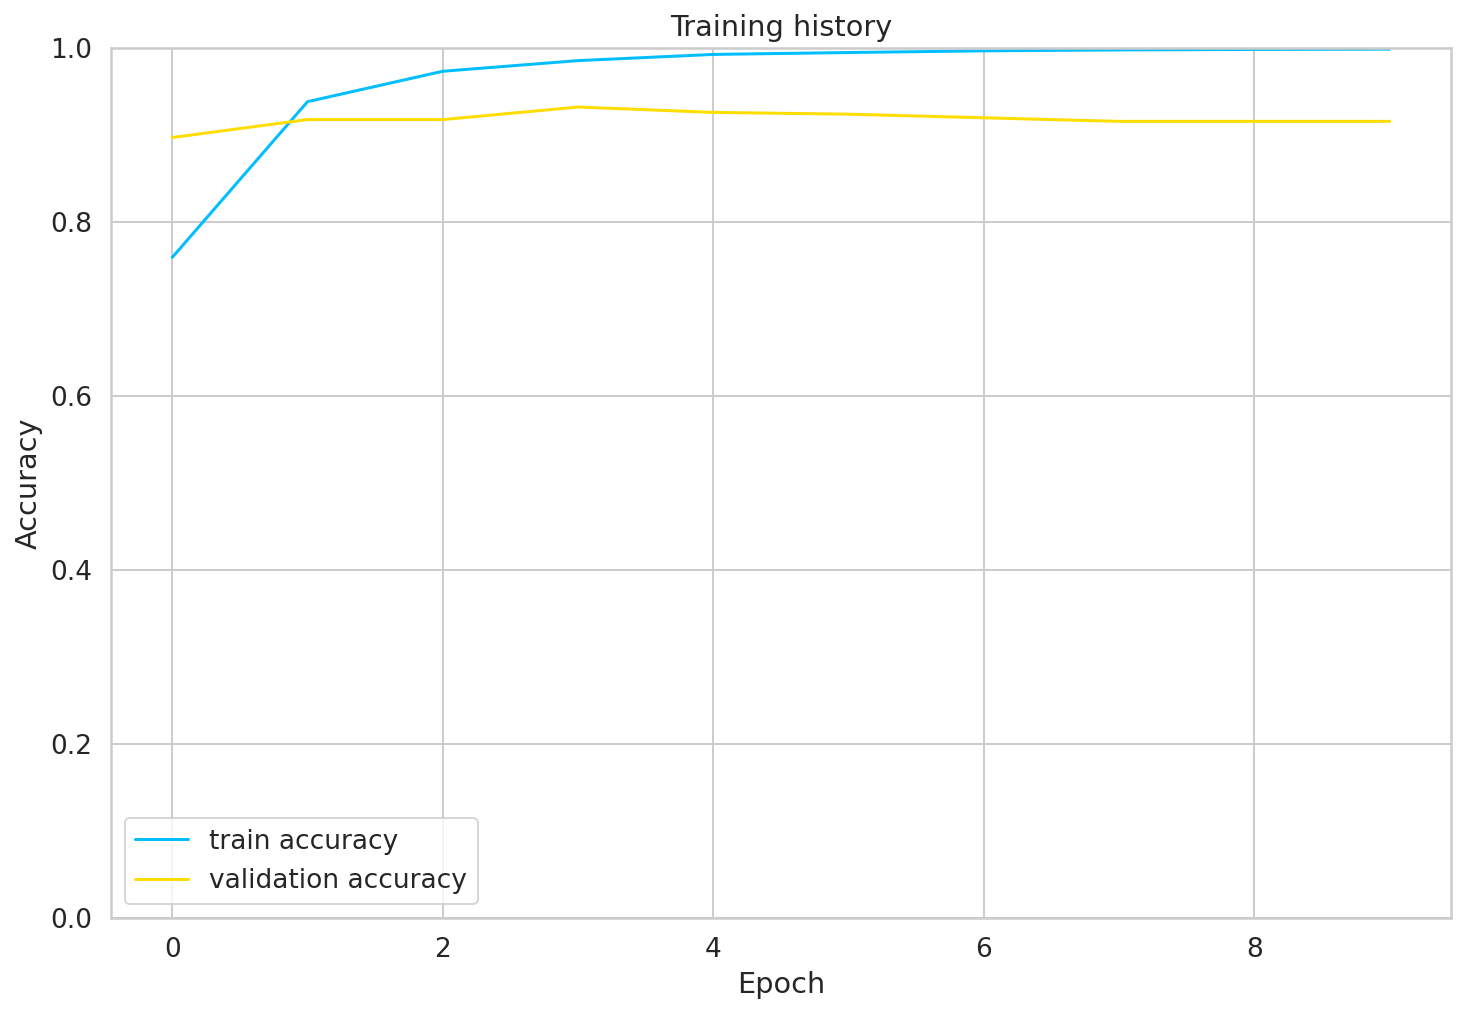

In [52]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The accuracy of the test data is very similar to that of the validation data:

In [53]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(test_acc)

0.931958762886598


This function evalutes the trained model on the test data to see how accurate it is 

In [54]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [55]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Here is the Classification Report

In [56]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.92      0.92       147
     neutral       0.97      0.95      0.96       182
    positive       0.91      0.92      0.91       156

    accuracy                           0.93       485
   macro avg       0.93      0.93      0.93       485
weighted avg       0.93      0.93      0.93       485



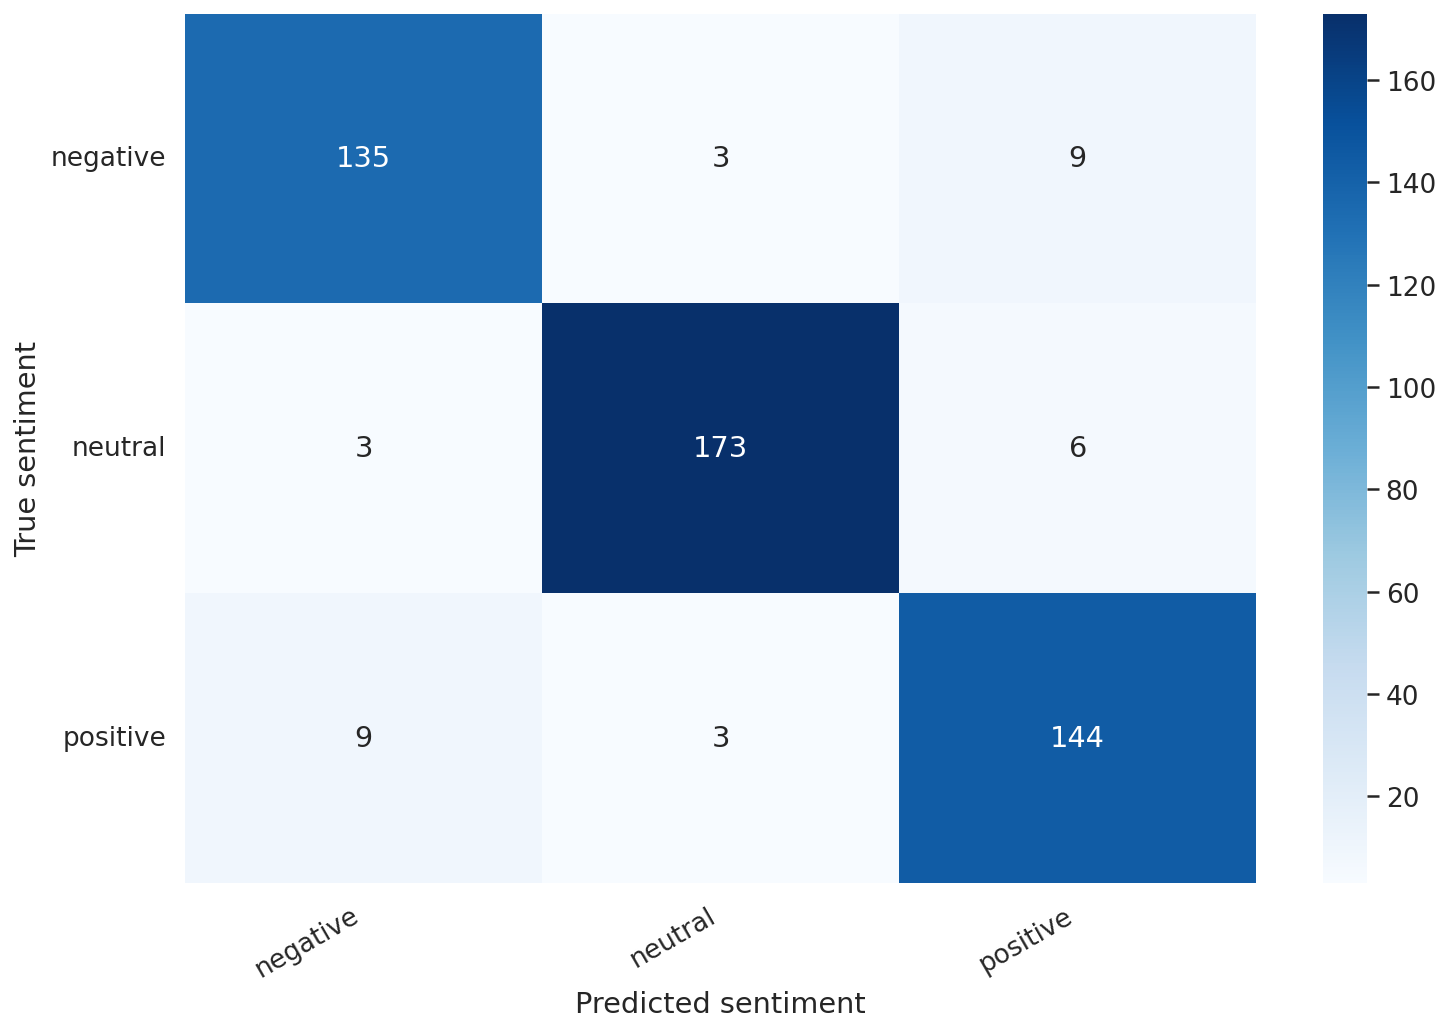

In [57]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [58]:
idx = 4

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [59]:
print("\n".join(wrap(tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Long Covid Covaxin Covid19 Unvaccinated

True sentiment: negative


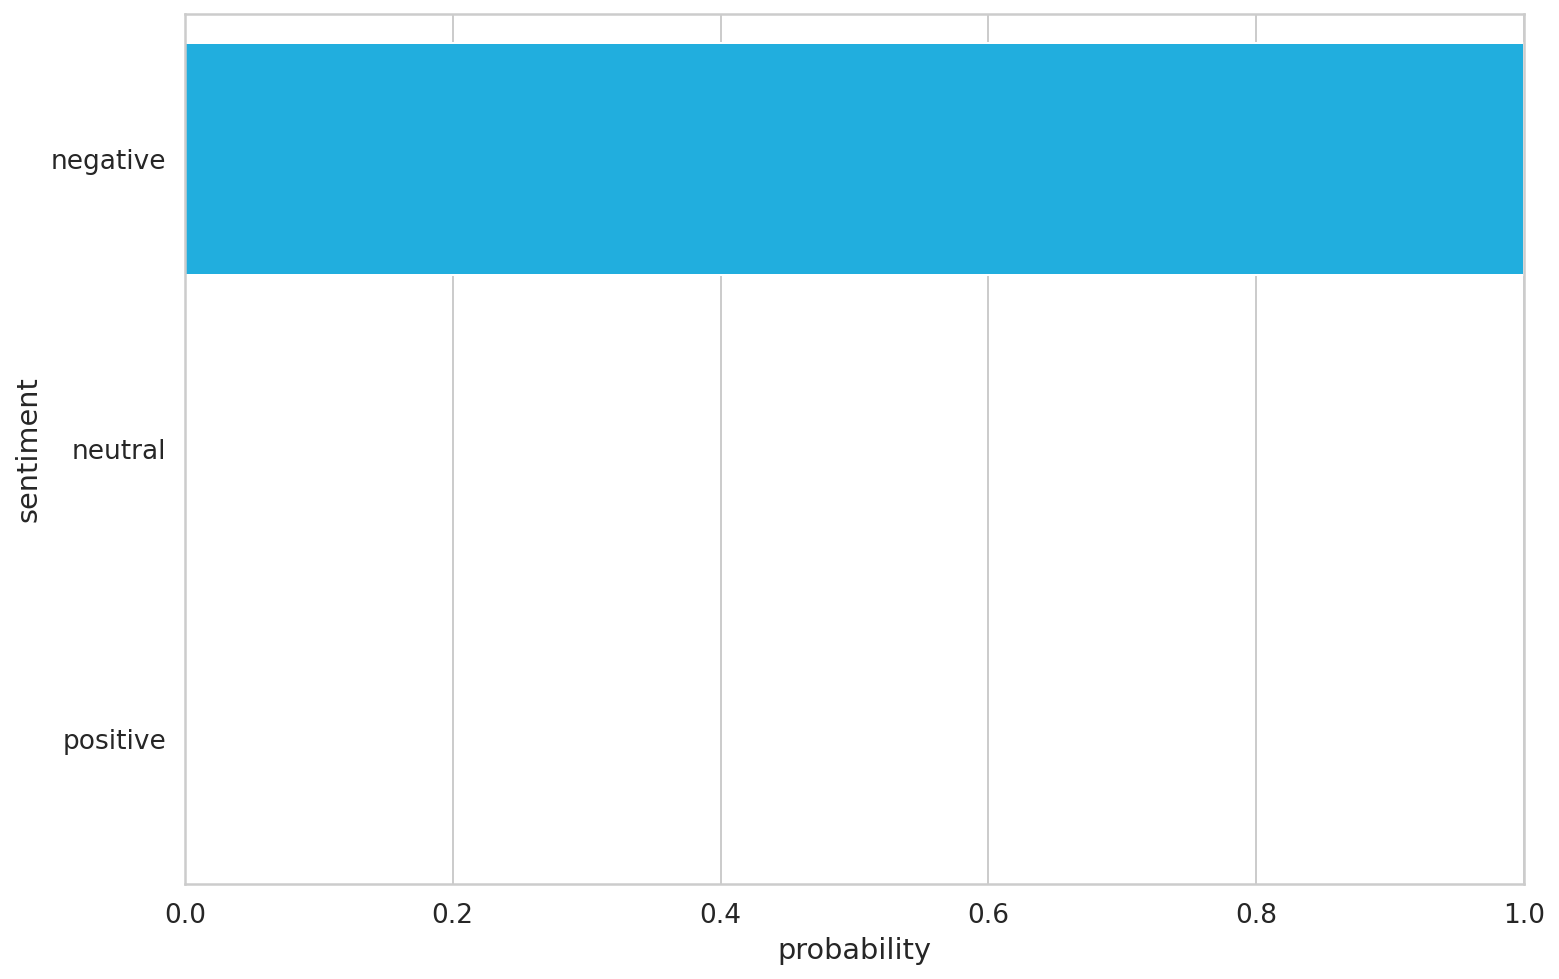

In [60]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

The model is also able to identify the sentiment of raw text such as shown below:

In [61]:
tweet_text = "The vaccine was great!"

In [62]:
encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [63]:
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)

output = model(input_ids, attention_mask,return_dict=False)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {tweet_text}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet text: The vaccine was great!
Sentiment  : positive


# References:
https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524


https://textblob.readthedocs.io/en/dev/advanced_usage.html#sentiment-analyzers

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://www.nbshare.io/notebook/754493525/Tweet-Sentiment-Analysis-Using-LSTM-With-PyTorch/

# Data visualization:

For the data visualization we put all the sentiment analysis and the new columns added with TextBlob into a new file

In [65]:
file = open("tweets_visual.csv", "a")
df.to_csv('tweets_visual.csv')